## Indicators (SMA, EMA, RSI)

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from datetime import datetime

In [93]:
def SMA(df, column="Close", period=20):
    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    if 'SMA'+str(period) in df.columns.values: df.drop('SMA'+str(period), axis=1, inplace=True)
    return df.join(sma.to_frame('SMA'+str(period)))

def EMA(df, column="Close", period=20):
    ema = df[column].ewm(span=period, min_periods=period - 1).mean()
    if 'EMA'+str(period) in df.columns.values: df.drop('EMA'+str(period), axis=1, inplace=True)
    return df.join(ema.to_frame('EMA'+str(period)))

def RSI(df, column="Close", period=14):
    delta = df[column].diff()
    up, down = delta.copy(), delta.copy()

    up[up < 0] = 0
    down[down > 0] = 0

    rUp = up.ewm(com=period - 1, min_periods=period, adjust=True).mean()
    rDown = down.ewm(com=period - 1,  min_periods=period, adjust=True).mean().abs()

    rsi = 100 - 100 / (1 + rUp / rDown)    

    if 'RSI'+str(period) in df.columns.values: df.drop('RSI'+str(period), axis=1, inplace=True)
    return df.join(rsi.to_frame('RSI'+str(period)))

def BollingerBand(df, column="Close", period=20):

    sma = df[column].rolling(window=period, min_periods=period - 1).mean()
    std = df[column].rolling(window=period, min_periods=period - 1).std()

    up = (sma + (std * 2)).to_frame('BBANDUP')
    lower = (sma - (std * 2)).to_frame('BBANDLO')
    return df.join(up).join(lower)

In [94]:
parser = lambda x: pd.Timestamp(datetime.fromtimestamp(int(x)/1000))
df = pd.read_csv("./data/2019-1-1-BTCUSDT-5m.csv", index_col="Open time", parse_dates=['Open time','Close time'], date_parser=parser)

In [127]:

d1 = pd.Timestamp('2019-01-4 22:00:00')
d2 = pd.Timestamp('2019-01-5 22:00:00')
#d3 = pd.Timestamp('2019-02-1 00:00:00')
d = df[d1:d2].copy()
#df2 = df[d3:d2].copy()

In [128]:
n=13 # number of points to be checked before and after 
m = 28 

# Find local peaks
d['min'] = d.iloc[argrelextrema(d.Close.values, np.less_equal, order=n)[0]]['Close']
#d['max'] = d.iloc[argrelextrema(d.Close.values, np.greater_equal, order=n)[0]]['Close']
#d = EMA(d, period=7)
#d = EMA(d, period=25)
#d = EMA(d, period=99)
d = RSI(d, period=14)
d['buy'] = d['Close'][(d['RSI14'].shift(2) < m) & (d['RSI14'].shift(1) < m) & (d['RSI14'] > m)]
#df2['limit'] = df2['Close'].cummax() * 0.995

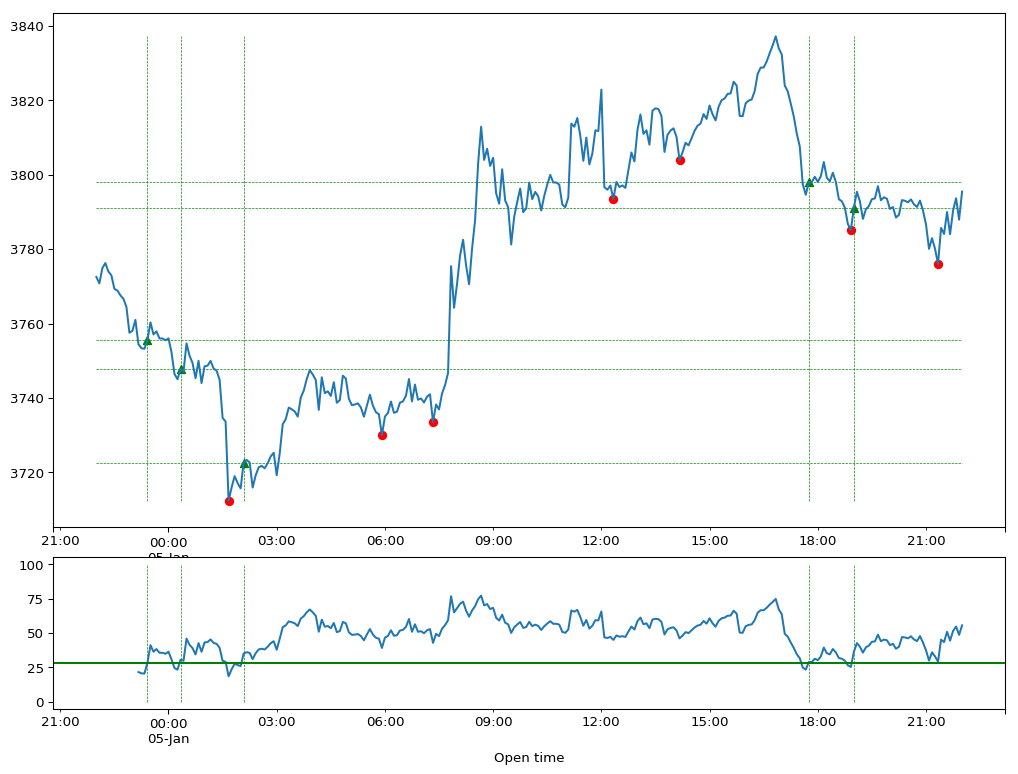

In [131]:
fig = plt.figure(figsize=(12.8, 9.6), dpi=96);
ax1 = fig.add_subplot(4,1,(1,3))

d["Close"].plot()
#d["EMA7"].plot()
#d["EMA25"].plot()
#d["EMA99"].plot()
#df2["limit"].plot()
plt.scatter(d.index, d['min'], c='r')
#plt.scatter(d.index, d['max'], c='g')
plt.scatter(d.index, d['buy'], c='g', marker='^')

plt.hlines(d['buy'].dropna(), xmin=d.iloc[0].name, xmax=d.iloc[-1].name, color='g', linestyle='--', linewidth=0.5)
plt.vlines(d['buy'].dropna().index, ymin=d['Close'].min(), ymax=d['Close'].max(), color='g', linestyle='--', linewidth=0.5)

ax2 = fig.add_subplot(414)
d["RSI14"].plot()
#plt.axhline(y=90, color='r', linestyle='-')
#plt.axhline(y=70, color='r', linestyle=':')
plt.axhline(y=m, color='g', linestyle='-')
plt.axvline(x=d.iloc[0].name, color='grey', linestyle='-', linewidth=0)
plt.vlines(d['buy'].dropna().index, ymin=0, ymax=100, color='g', linestyle='--', linewidth=0.5)